# DeepAR implementations in GluonTS and PyTorchTS

@author: Korbinian Kuusisto, https://github.com/kkuusisto

This notebook served as complementary material for the [Berlin Time Series Meetup](https://www.meetup.com/Berlin-Time-Series-Analysis-Meetup/events/273248909/) hosted on Tue, Oct 13 7:00 PM GMT+2.

The topic can be found in the event and was organised as a book club like session to explore Amazon's DeepAR model.

This notebook combines two example notebooks from the GluonTS and PyTorchTS repositories, makes them consistent in order to compare both frameworks.

- GluonTS: https://github.com/awslabs/gluon-ts/blob/master/examples/m5_gluonts_template.ipynb
- PyTorchTS: https://github.com/zalandoresearch/pytorch-ts/blob/master/examples/m5.ipynb

We are using the [M5 forecasting competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview) data, which is available on Kaggle (https://www.kaggle.com/c/m5-forecasting-accuracy/data). You first need to agree to the terms of the competition before being able to download the data. After you have done that, please copy the files into `../../data/m5-forecasting-accuracy`.



## Imports

In [1]:
import mxnet as mx
from mxnet import gluon
import torch

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import json
import os
from tqdm.autonotebook import tqdm
from pathlib import Path

We also define globally accessible variables, such as the prediction length and the input path for the M5 data. Note that `prediction_length` corresponds to the length of the validation/evaluation periods.

In [4]:
prediction_length = 28
context_length = prediction_length * 2
m5_input_path="../../data/m5-forecasting-accuracy"

## Reading the M5 data and transforming it to ListDataset

First we need to convert the provided M5 data into a format that is readable by GluonTS and PyTorchTS. At this point we assume that the M5 data, which can be downloaded from Kaggle, is present under `m5_input_path`.

In [5]:
calendar = pd.read_csv(f'{m5_input_path}/calendar.csv')
sales_train_validation = pd.read_csv(f'{m5_input_path}/sales_train_validation.csv')

### Building dynamic features

We start the data convertion process by building dynamic features (features that change over time, just like the target values). Here, we are mainly interested in the event indicators `event_type_1` and `event_type_2`. We will mostly drop dynamic time features as GluonTS will automatically add some of these as part of many models' transformation chains.

In [140]:
cal_features = calendar.drop(
    ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'd'], 
    axis=1
)
cal_features['event_type_1'] = cal_features['event_type_1'].apply(lambda x: 0 if str(x)=="nan" else 1)
cal_features['event_type_2'] = cal_features['event_type_2'].apply(lambda x: 0 if str(x)=="nan" else 1)

cal_features = cal_features.values.T

train_cal_features = cal_features[:,:-context_length-prediction_length]
test_cal_features = cal_features[:,:-context_length]

# We replicate the dynamic features for each sample in our training set
test_cal_features_list = [test_cal_features] * len(sales_train_validation)
train_cal_features_list = [train_cal_features] * len(sales_train_validation)

### Building static features

We then go on to build static features (features which are constant and series-specific). Here, we make use of all categorical features that are provided to us as part of the M5 data.

In [141]:
state_ids = sales_train_validation["state_id"].astype('category').cat.codes.values
state_ids_un , state_ids_counts = np.unique(state_ids, return_counts=True)

store_ids = sales_train_validation["store_id"].astype('category').cat.codes.values
store_ids_un , store_ids_counts = np.unique(store_ids, return_counts=True)

cat_ids = sales_train_validation["cat_id"].astype('category').cat.codes.values
cat_ids_un , cat_ids_counts = np.unique(cat_ids, return_counts=True)

dept_ids = sales_train_validation["dept_id"].astype('category').cat.codes.values
dept_ids_un , dept_ids_counts = np.unique(dept_ids, return_counts=True)

item_ids = sales_train_validation["item_id"].astype('category').cat.codes.values
item_ids_un , item_ids_counts = np.unique(item_ids, return_counts=True)

stat_cat_list = [item_ids, dept_ids, cat_ids, store_ids, state_ids]

stat_cat = np.concatenate(stat_cat_list)
stat_cat = stat_cat.reshape(len(stat_cat_list), len(item_ids)).T

stat_cat_cardinalities = [len(item_ids_un), len(dept_ids_un), len(cat_ids_un), len(store_ids_un), len(state_ids_un)]

### Transforming to ListDataset

Finally, we can build both the training and the testing set from target values and both static and dynamic features. We implicitly "train_test_split" by including the window of length predition_length only in the test set.

In [171]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

df = sales_train_validation.drop(["id","item_id","dept_id","cat_id","store_id","state_id"], axis=1)
target_values = df.values

test_target_values = target_values.copy()
train_target_values = [ts[:-prediction_length] for ts in df.values]

m5_dates = [pd.Timestamp("2011-01-29", freq='1D') for _ in range(len(df))]

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(train_target_values,
                                         m5_dates,
                                         train_cal_features_list,
                                         stat_cat)
], freq="D")

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(test_target_values[:1000],
                                         m5_dates[:1000],
                                         test_cal_features_list[:1000],
                                         stat_cat[:1000])
], freq="D")

Just to be sure, we quickly verify that dataset format is correct and that our dataset does indeed contain the correct target values as well as dynamic and static features.

In [172]:
next(iter(train_ds))

{'target': array([0., 0., 0., ..., 1., 1., 1.], dtype=float32),
 'start': Timestamp('2011-01-29 00:00:00', freq='D'),
 'feat_dynamic_real': array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'feat_static_cat': array([1437,    3,    1,    0,    0], dtype=int32),
 'source': SourceContext(source='list_data', row=0)}

# Gluon-TS

### Estimator with Gluon-TS

Having obtained our training and testing data, we can now create a GluonTS estimator. In our example we will use the `DeepAREstimator`, an autoregressive RNN which was developed primarily for the purpose of time series forecasting. Note however that you can use a variety of different estimators. Also, since GluonTS is mainly target at probabilistic time series forecasting, lots of different output distributions can be specified. In the M5 case, we think that the `NegativeBinomialOutput` distribution best describes the output.

For a full list of available estimators and possible initialization arguments see https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.html.

For a full list of available output distributions and possible initialization arguments see https://gluon-ts.mxnet.io/api/gluonts/gluonts.distribution.html.

In [174]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.trainer import Trainer

epochs = 2 # For the purpose of demonstration ;)

estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="D",
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=True,
    use_feat_static_cat=True,
    cardinality=stat_cat_cardinalities,
    context_length=context_length,
    trainer=Trainer(
        learning_rate=1e-3,
        epochs=epochs,
        num_batches_per_epoch=50,
        batch_size=32
    )
)

predictor = estimator.train(train_ds)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  9.33it/s, epoch=2/2, avg_epoch_loss=1.17]


### Generating forecasts

Once the estimator is fully trained, we can generate predictions for the test values. GluonTS comes with the make_evaluation_predictions function that automates all this procedure. Roughly, this module performs the following steps:

- Removes the final window of length prediction_length of the dataset that we want to predict
- The estimator uses the remaining dataset to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs a generator over the forecasted sample paths and a generator over the dataset

In [145]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...



Obtaining time series predictions ...


### Calculate performance metrics

Using the test data, we can calculate a set of evaluation metrics

In [146]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

pd.DataFrame.from_dict(agg_metrics, columns=['Metric'], orient='index').head(10)

Running evaluation: 100%|██████████| 1000/1000 [00:00<00:00, 12649.26it/s]


,Metric
MSE,4.324651
abs_error,26326.000000
abs_target_sum,32564.000000
abs_target_mean,1.163000
seasonal_error,0.928159
MASE,1.186725
MAPE,0.332795
sMAPE,0.722244
OWA,NaN
MSIS,10.970895


### Plotting sample predictions

Finally, we can also visualize our predictions for some of the time series.

Plotting time series predictions ...


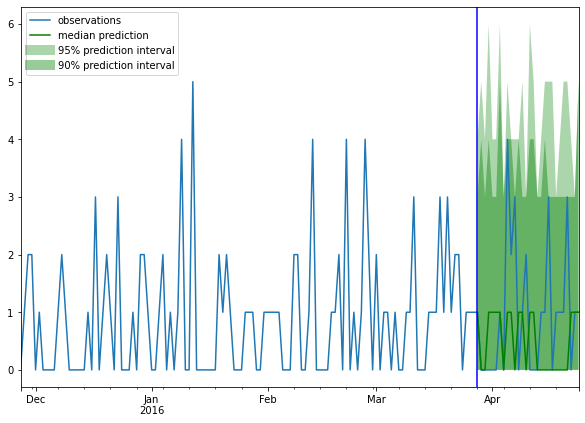

<Figure size 432x288 with 0 Axes>

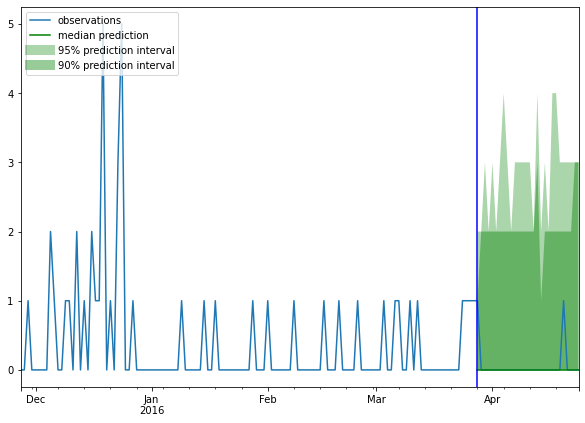

<Figure size 432x288 with 0 Axes>

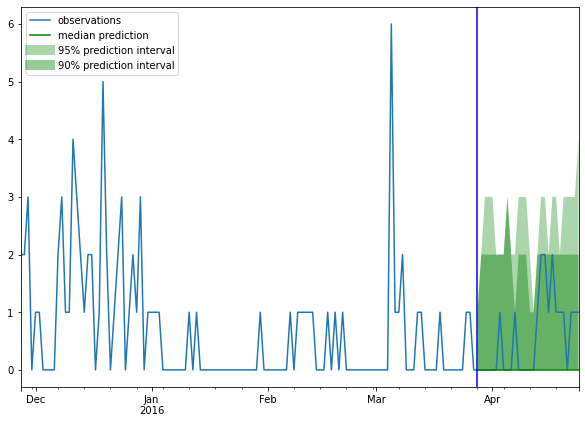

<Figure size 432x288 with 0 Axes>

In [153]:
num_plots = 3

def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id):
    plot_length = 150
    prediction_intervals = (90, 95)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='b')
    plt.legend(legend, loc="upper left")
    plt.show()
    plt.clf()

print("Plotting time series predictions ...")
for i in range(len(test_ds)):
    if i > num_plots - 1:
        break
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)

# PyTorch-TS

Same as with Gluon-TS, we define an Estimator and train the model on our training data. The syntax is almost the same compared to Gluon-TS. However, under the hood, the Estimator is using PyTorch.

In [178]:
from pts.model.deepar import DeepAREstimator
from pts.modules import NegativeBinomialOutput
from pts import Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set GPU usage here directly

epochs = 2 # For the purpose of demonstration ;)

estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="D",
    distr_output=NegativeBinomialOutput(),
    use_feat_dynamic_real=True,
    use_feat_static_cat=True,
    cardinality=stat_cat_cardinalities,
    context_length=context_length,
    input_size=104,
    trainer=Trainer(
                    learning_rate=1e-3,
                    epochs=2,
                    num_batches_per_epoch=50,
                    batch_size=32,
                    device=device,
                   )
)

predictor = estimator.train(train_ds)

49it [00:03, 14.83it/s, avg_epoch_loss=1.04, epoch=0]
49it [00:03, 15.08it/s, avg_epoch_loss=0.938, epoch=1]


### Calculate performance metrics

Same as for Gluon-TS, we can calculate a set of evaluation metrics

In [179]:
from pts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor,
    num_samples=100,
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...



Obtaining time series predictions ...


### Calculate performance metrics

Using the test data, we can calculate a set of evaluation metrics

In [180]:
from pts.evaluation import Evaluator

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

pd.DataFrame.from_dict(agg_metrics, columns=['Metric'], orient='index').head(10)

Running evaluation: 100%|██████████| 1000/1000 [00:00<00:00, 19371.89it/s]


,Metric
MSE,4.300991
abs_error,25938.000000
abs_target_sum,32564.000000
abs_target_mean,1.163000
seasonal_error,0.928159
MASE,1.176512
MAPE,0.288016
sMAPE,0.720918
OWA,NaN
MSIS,10.010767


### Plotting sample predictions

Plotting time series predictions ...


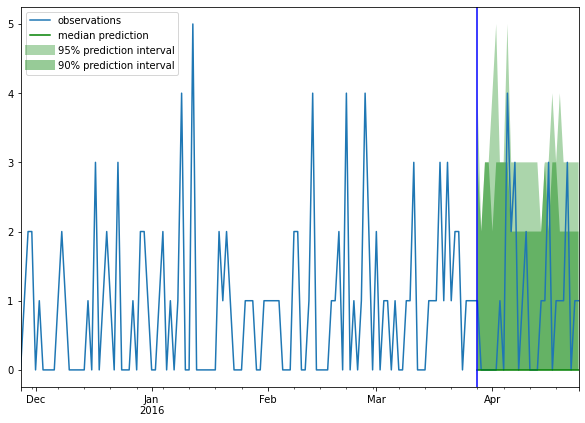

<Figure size 432x288 with 0 Axes>

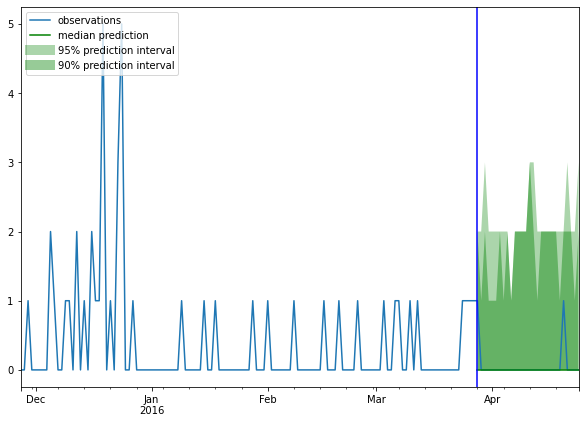

<Figure size 432x288 with 0 Axes>

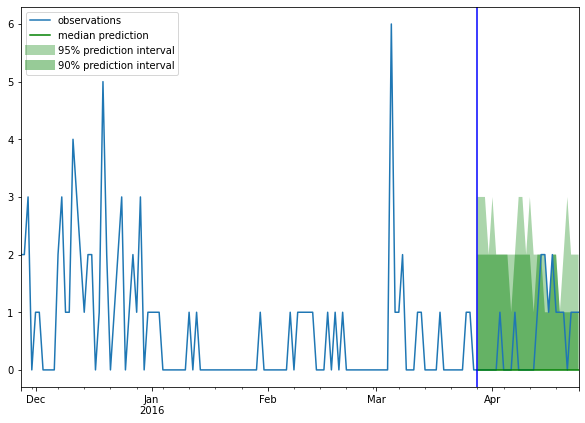

<Figure size 432x288 with 0 Axes>

In [181]:
num_plots = 3

print("Plotting time series predictions ...")
for i in range(len(test_ds)):
    if i > num_plots - 1:
        break
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)